In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/MyDrive/ML_A3/

/content/drive/MyDrive/ML_A3


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset


import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import copy
import pickle
from sklearn.decomposition import PCA, TruncatedSVD
import seaborn as sns
import torchvision.models as models
import torch.nn.functional as F
import cv2

In [4]:
import torch.utils.data as data_utils

In [ ]:
# reading and parsing data files

In [5]:
f = open('train_CIFAR.pickle', "rb")
df_train = pickle.load(f)
f.close()

In [6]:
f = open("test_CIFAR.pickle", "rb")
df_test = pickle.load(f)
f.close()

In [7]:
X_train = df_train['X']
y_train = df_train['Y']

In [8]:
X_test = df_test['X']
y_test = df_test['Y']

In [ ]:
# Code for EDA

In [9]:
print(np.unique(y_train, return_counts = True))

(array([0, 1]), array([5000, 5000]))


In [ ]:
# SVD for dimensionality reduction

In [10]:
svd = TruncatedSVD(n_components = 2)
X_t = svd.fit_transform(X_train)

In [ ]:
# Scatter plot code

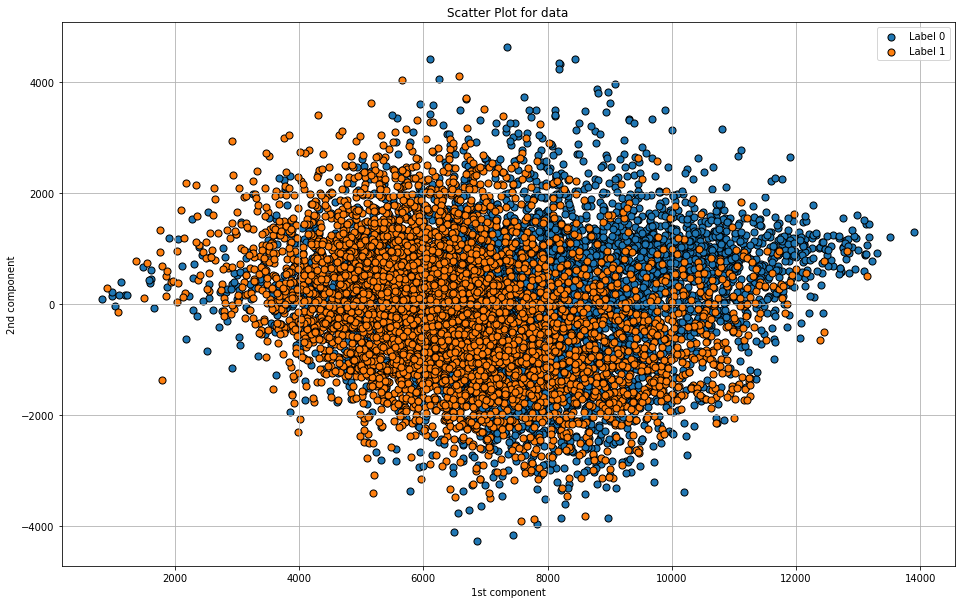

In [11]:
plt.figure(figsize=(16,10))
plt.scatter(
    X_t[y_train == 0, 0], X_t[y_train == 0, 1],
    s=50,
    edgecolor='black',
    label='Label 0'
)
plt.scatter(
    X_t[y_train == 1, 0], X_t[y_train == 1, 1],
    s=50,
    edgecolor='black',
    label='Label 1'
)

plt.xlabel("1st component")
plt.ylabel("2nd component")
plt.title("Scatter Plot for data")
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

In [12]:

# reshaping data and normalizing
y_test=np.array(df_test["Y"])
y_train=np.array(df_train["Y"])

num=3072//3
l=[0,num,2*num,3*num]
L=[]
for i in range(3):
  L.append(df_train["X"][:,l[i]:l[i+1]].reshape(df_train["X"].shape[0],32,32,1))

X_train=np.concatenate(L,-1)


L=[]
for i in range(3):
  L.append(df_test["X"][:,l[i]:l[i+1]].reshape(df_test["X"].shape[0],32,32,1))

X_test=np.concatenate(L,-1)



In [13]:
# Normalizing the data
VAL=255
M=X_train.mean(axis=(0,1,2))/VAL
S=X_train.std(axis=(0,1,2))/VAL
X_train_normalised=transforms.Normalize(mean=M,std=S)

M=X_test.mean(axis=(0,1,2))/VAL
S=X_test.std(axis=(0,1,2))/VAL
X_test_normalised=transforms.Normalize(mean=M,std=S)

In [14]:
class CustomDataset(Dataset):
    # class for feeding our own datafile into pytorch
    def __init__(self, X, y=None, transform = None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return (len(self.X))

    def __getitem__(self, i):
        image=Image.fromarray(self.X[i])
        y=self.y[i]

        if self.transform is not None:
            image=self.transform(image)
        
        return image,y
    


In [15]:
train_transforms = transforms.Compose([
                            transforms.Resize(224),
                            transforms.RandomHorizontalFlip(),
                           transforms.ToTensor(),
                           X_train_normalised
                          
                       ])

test_transforms = transforms.Compose([
                            transforms.Resize(224), 
                            
                           transforms.ToTensor(),
                           X_test_normalised

                           
                       ])

In [ ]:
# creating dataset object

In [16]:
train_data = CustomDataset(X_train, y_train, transform = train_transforms)
test_data = CustomDataset(X_test, y_test, transform = test_transforms)


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# creating iteraotrs

In [18]:
train_iterator = data_utils.DataLoader(train_data, batch_size = 64, shuffle=True)

In [19]:
test_iterator = data_utils.DataLoader(test_data, batch_size = 64, shuffle=True)

In [20]:
AlexNet = models.alexnet(pretrained = True)


In [21]:
class MLP(nn.Module):
    # class for MLP implementation in pytorch
    def __init__(self, input_dim, output_dim, num_neurons):
        super().__init__()
        print(input_dim, num_neurons[0])
        print(num_neurons[0], num_neurons[1])
        print(num_neurons[1], output_dim)


        self.input_to_hidden1 = nn.Linear(1000,512)
        self.hidden1_to_hidden2 = nn.Linear(512,256)
        self.hidden2_to_output = nn.Linear(256,2)
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)                
        h_1 = F.relu(self.input_to_hidden1(x))
        h_2 = F.relu(self.hidden1_to_hidden2(h_1))
        y_pred = self.hidden2_to_output(h_2)
    
        return y_pred, h_2

In [22]:
input_dimensions = len(X_train[0])
output_dimensions = 2


In [23]:
def calculate_accuracy(y_pred, y):
    # returns accuracy
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [24]:
def train(model, iterator, optimizer, criterion, device):
    """
    Trains model and returns loss
    """
    
    
    epoch_loss = 0
    acc_sum = 0
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        AlexNet.to(device)

        y_pred, _ = model(AlexNet(x).float())
        loss = criterion(y_pred, y)
        acc_sum += calculate_accuracy(y_pred, y).item()

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return (epoch_loss / len(iterator)), (acc_sum/len(iterator))

In [25]:
def evaluate(model, iterator, criterion, device):
    """
    returns accuracy and loss for the given iterator by the input model

    """
    
    epoch_loss = 0
    acc_sum = 0
    model.eval()
    
    with torch.no_grad():
    
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            AlexNet.to(device)
            y_pred, _ = model(AlexNet(x).float())


            loss = criterion(y_pred, y)
            acc_sum += calculate_accuracy(y_pred, y).item()

            epoch_loss += loss.item()
        
    return (epoch_loss / len(iterator)), (acc_sum/len(iterator))

In [26]:
# running the neural network model
model = MLP(1000, 2, [512, 256])
optimizer = optim.Adam(model.parameters(), lr = 0.1)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
AlexNet.to(device)
criterion = criterion.to(device)
num_epochs = 1


for i in range(num_epochs):
  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
  val_loss, val_acc = evaluate(model, test_iterator, criterion, device)
  print("Train acc: ", train_acc, " Test acc: ", val_acc)


1000 512
512 256
256 2
Train acc:  0.8597730891719745  Test acc:  0.90966796875
